# Active Inference Interoception Model

In this notebook, I will lay out the mathematics and implementation of an active inference model of interoception, based on Karl Friston's Free Energy Principle. The model is inspired by Bogacz's tutorial for modeling perception using active inference. The implementation is borrowed and edited from Andre van Schaik's Jupyter notebook conversion of the article. I will be explicit about which code is borrowed and which is original.

### Assumptions and variables for the model
In the first model below, assume there is a single variable inferred from a single observation. In our example, we can assume that the agent is inferring the length of breath inhalation (interoceptive ability), $v$, on the basis of interoceptive signals observed, $u$.

For these models, we can assume the sensory input is noisy, so when the breath inhale length is $v$, the perceived interoceptive signalis normally distributed with mean $g(v)$ and variance $\Sigma_u$.

Below are the sybmols used in the model:

$v$ = length of breath inhalation

$g(v)=v^2$ = non-linear function relating average interoceptive signal with breath inhalation length. (more research here)

$v_p$ = mean length of breath inhalation (prior)

$\Sigma_p$ = variance of length of breath inhalation (prior)

$u$ = interoceptive signal observed

$\Sigma_u$ = variance in interoceptive signal, basically noise

$\phi$ = approximation of most likely length of breath inhalation

Currently, we will use a normal distribution, which is probably not realistic for breath inhalation length

$$p(\phi) = f(\phi; v_p, \Sigma_p)$$

$$p(u|\phi) = f(u;g(\phi),\Sigma_u)$$

Next, I will write out some derivations from the paper. What do we want to compute? We want to maximize $p(\phi|u)$, which is the probability of the inhale length approximation given the interoceptive signal. This amounts to maximizing:

$$p(\phi|u) = \frac{p(\phi)p(u|\phi)}{p(u)}$$

Since $p(u)$ (denominator) doesn't depend on $\phi$, we can simply maximize the numerator and it will provide the same answer, but un-scaled. Next, we can find the logarithm of the numnerator, which will again provide the same answer, but scaled differently. This is fine, however, since log is monotonic. Call this equation F:

$$F = \ln p(\phi) + \ln p(u|\phi)$$

This function relates to Free Energy. I'll include more here in a bit, but for now that is sufficient. 

We can maximize F by finding the maximum of F's gradient with respect to $\phi$. First, we compute $F$ by substituting the relevant formulas. The following is taken from the paper:

\begin{align*}
F  &= \ln p(\phi) + \ln p(u|\phi) \\
&= \ln f(\phi; v_p,\Sigma_p) + \ln f(u; g(\phi), \Sigma_u) \\
&= \ln \left[ \frac{1}{\sqrt{2 \pi \Sigma_p}} \exp \left(-\frac{(\phi - v_p)^2}{2 \Sigma_p}\right)\right] 
+ \ln \left[ \frac{1}{\sqrt{2 \pi \Sigma_u}} \exp \left(-\frac{(u - g(\phi))^2}{2 \Sigma_u}\right)\right] \\
&= \ln \frac{1}{\sqrt{2 \pi}} - \frac{1}{2} \ln \Sigma_p - \frac{(\phi - v_p)^2}{2 \Sigma_p} 
+ \ln \frac{1}{\sqrt{2 \pi}} - \frac{1}{2} \ln \Sigma_u - \frac{(u - g(\phi))^2}{2 \Sigma_u} \\
&= \frac{1}{2} \left( -\ln \varSigma_p - \frac{(\phi - v_p)^2}{\Sigma_p} - \ln \Sigma_u - \frac{(u - g(\phi))^2}{\Sigma_u} \right) + C. 
\end{align*}

Above, C is the constants.

### Simulate the model with the following parameters:

Exercise 1.Assume that our animal observed the light intensity u=2, the level of noise in its receptor is Σu=1, and the mean and variance of its prior expectation of size are vp=3 and Σp=1. Write a computer program that computes the posterior probabilities of sizes from 0.01 to 5, and plots them.

Initialize $\phi=v_p, \epsilon_p=\epsilon_u=0$

Useful equations: 
$\frac{\partial F}{\partial \phi} = \frac{v_p - \phi}{\sum_p} + \frac{u-g(\phi)}{\sum_u}g'(\phi)$.
Note that $g(\phi) = 2\phi$

$\dot \phi = \frac{\partial F}{\partial \phi}$

-------------------------------
$\epsilon_p$ = $\frac{\phi-v_p}{\sum_p}$, where $\epsilon_p$ is prediction error between inferred size and prior expectations.

$\epsilon_u$ = $\frac{u-g(\phi)}{\sum_u}$, where $\epsilon_u$ is prediction error between light intensity and expected size of food, $\phi$. So $\phi$ update now simplifies to:

$\dot \phi = \epsilon_u g'(\phi) - \epsilon_p$

-------------------------------

##### Note: Neural implmentation
$v_p$, $\sum_p$, and $\sum_u$ assumed to be encoded in strengths of synaptic connections.

$\phi$, $\epsilon_u$, and $\epsilon_p$ and sensory input $u$ assumed to be maintained in activity of neurons or neuronal populations.

-------------------------------

Updating prediction errors:

$\dot \epsilon_p = \phi - v_p - \sum_p \epsilon_p$

$\dot \epsilon_u = u - g(\phi) - \sum_u \epsilon_u$

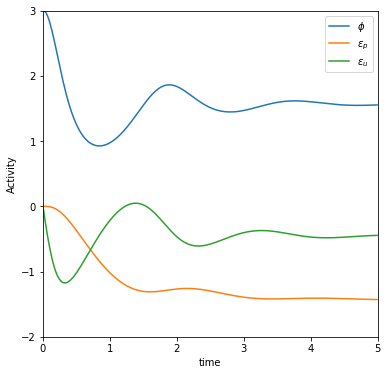

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import matplotlib

def g(phi):
    return phi**2

def epsilon_p_dot(phi, v_p, sigma, epsilon_p):
    return phi - v_p - (sigma * epsilon_p)

def epsilon_u_dot(u, phi, sigma, epsilon_u):
    return u - g(phi) - (sigma * epsilon_u)


def iteration_one_model():
    u       = 2
    sigma_u = 1
    v_p     = 3
    sigma_p = 1
    phi     = v_p
    dt      = 0.01
    dur     = 5
    steps   = int(dur/dt)
    epsilon_p = 0
    epsilon_u = 0

    trace_phi    = np.zeros(steps)
    trace_phi[0] = phi
    
    trace_epsilon_p = np.zeros(steps)
    trace_epsilon_p[0] = epsilon_p
    
    trace_epsilon_u = np.zeros(steps)
    trace_epsilon_u[0] = epsilon_u

    for t in range(steps-1):
        # First calc phi next timestep
        phi += dt * (epsilon_u * 2*phi - epsilon_p)
        trace_phi[t+1] = phi
        
        #calculate epsilons' next timesteps
        epsilon_p += dt * epsilon_p_dot(phi, v_p, sigma_p, epsilon_p)
        trace_epsilon_p[t+1] = epsilon_p
        
        epsilon_u += dt * epsilon_u_dot(u, phi, sigma_u, epsilon_u)
        trace_epsilon_u[t+1] = epsilon_u

    fig = plt.figure(figsize=(6,6), num='Fig 2b')
    ax  = fig.add_subplot(1, 1, 1)

    ax.plot(np.arange(steps) * dt, trace_phi)
    ax.plot(np.arange(steps) * dt, trace_epsilon_p)
    ax.plot(np.arange(steps) * dt, trace_epsilon_u)
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\phi$', r'$\epsilon_p$',r'$\epsilon_u$'])
    plt.axis([0, 5, -2, 3])
    
iteration_one_model()

### Updating Model Parameters

Next, we will turn to updating the model parameters. This includes variables like $v_p$, $\Sigma_p$, and $\Sigma_u$. We want to update parameters such that the difference between expectation and observation is minimized (predictions are more accurate). This means we must compute the gradient of F with respect to each of these variables to determine their update rules:

\begin{align*}
F &= \frac{1}{2} \left( -\ln \varSigma_p - \frac{(\phi - v_p)^2}{\Sigma_p} - \ln \Sigma_u - \frac{(u - g(\phi))^2}{\Sigma_u} \right) + C. 
\end{align*}


The calculations are simple:

$$\frac{\partial F}{\partial v_p} = \frac{\phi - v_p}{\Sigma_p}$$

$$\frac{\partial F}{\Sigma_p} = \frac{1}{2} \left( \frac{(\phi-v_p)^2}{\Sigma_p^2} - \frac{1}{\Sigma_p} \right)$$

$$\frac{\partial F}{\Sigma_u} = \frac{1}{2} \left( \frac{(u-g(\phi))^2}{\Sigma_u^2} - \frac{1}{\Sigma_u} \right)$$

Thus, we get:

$$\frac{\partial F}{\partial v_p} = \epsilon_p$$

$$\frac{\partial F}{\Sigma_p} = \frac{1}{2} \left( \epsilon_p^2 - \frac{1}{\Sigma_p} \right)$$

$$\frac{\partial F}{\Sigma_u} = \frac{1}{2} \left( \epsilon_u^2 - \frac{1}{\Sigma_u} \right)$$

We will implement the model below, in which parameters are updated:

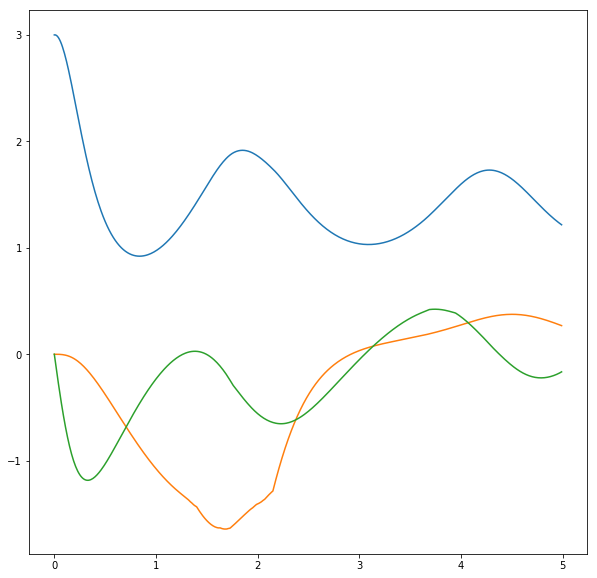

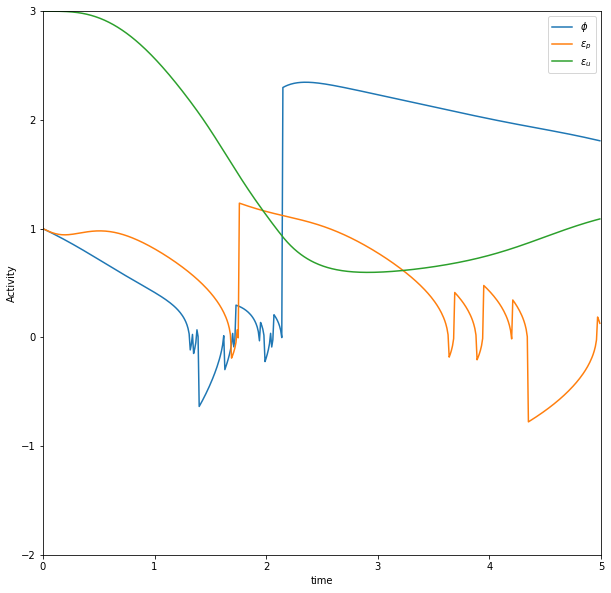

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import matplotlib

def g(phi):
    return phi**2

def epsilon_p_dot(phi, v_p, sigma, epsilon_p):
    return phi - v_p - (sigma * epsilon_p)

def epsilon_u_dot(u, phi, sigma, epsilon_u):
    return u - g(phi) - (sigma * epsilon_u)

def v_p_dot(epsilon_p):
    return epsilon_p

def sigma_p_dot(epsilon_p, sigma_p):
    return (1.0/2.0) * (epsilon_p**2 - (1/sigma_p))

def sigma_u_dot(epsilon_u, sigma_u):
    return (1.0/2.0) * (epsilon_u**2 - (1/sigma_u))

def iteration_two_model():
    u       = 2
    sigma_u = 1
    v_p     = 3
    sigma_p = 1
    phi     = v_p
    dt      = 0.01
    dur     = 5
    steps   = int(dur/dt)
    epsilon_p = 0
    epsilon_u = 0

    trace_phi    = np.zeros(steps)
    trace_phi[0] = phi
    
    trace_epsilon_p = np.zeros(steps)
    trace_epsilon_p[0] = epsilon_p
    
    trace_epsilon_u = np.zeros(steps)
    trace_epsilon_u[0] = epsilon_u
    
    trace_sigma_p = np.zeros(steps)
    trace_sigma_p[0] = sigma_p
    
    trace_sigma_u = np.zeros(steps)
    trace_sigma_u[0] = sigma_u
    
    trace_v_p = np.zeros(steps)
    trace_v_p[0] = v_p

    for t in range(steps-1):
        # First calc phi next timestep
        phi += dt * (epsilon_u * 2*phi - epsilon_p)
        trace_phi[t+1] = phi
        
        #calculate epsilons' next timesteps
        epsilon_p += dt * epsilon_p_dot(phi, v_p, sigma_p, epsilon_p)
        trace_epsilon_p[t+1] = epsilon_p
        
        epsilon_u += dt * epsilon_u_dot(u, phi, sigma_u, epsilon_u)
        trace_epsilon_u[t+1] = epsilon_u
        
        sigma_p += dt * sigma_p_dot(epsilon_p, sigma_p)
        trace_sigma_p[t+1] = sigma_p
        
        sigma_u += dt * sigma_u_dot(epsilon_u, sigma_u)
        trace_sigma_u[t+1] = sigma_u
        
        v_p += dt * v_p_dot(epsilon_p)
        trace_v_p[t+1] = v_p

    fig = plt.figure(figsize=(10,10), num='Fig 2b')
    ax  = fig.add_subplot(1, 1, 1)

    ax.plot(np.arange(steps) * dt, trace_phi)
    ax.plot(np.arange(steps) * dt, trace_epsilon_p)
    ax.plot(np.arange(steps) * dt, trace_epsilon_u)
    
    fig2 = plt.figure(figsize=(10,10))
    plt.plot(np.arange(steps) * dt, trace_sigma_p)
    plt.plot(np.arange(steps) * dt, trace_sigma_u)
    plt.plot(np.arange(steps) * dt, trace_v_p)
    
    
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\phi$', r'$\epsilon_p$',r'$\epsilon_u$',r'$\Sigma_p$', r'$\Sigma_u$', r'$v_p$'])
    plt.axis([0, 5, -2, 3])
    
iteration_two_model()

In [28]:
1/2 + 0.5

1.0